In [41]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import nn, resnet, sim
#from cfgs.fedargs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [43]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

<h1>Gender: ResNet</h1>

In [44]:
df = pd.read_csv('../../data/celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Eyeglasses'])

df1 = df[df['Eyeglasses'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 13193


,Male
202541.jpg,1
202568.jpg,1
202588.jpg,1
202590.jpg,1
202597.jpg,1


In [45]:
df2 = pd.read_csv('../../data/celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [46]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202541.jpg,1,2
202568.jpg,1,2
202588.jpg,1,2
202590.jpg,1,2
202597.jpg,1,2


In [47]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202541.jpg,1,2
202568.jpg,1,2
202588.jpg,1,2
202590.jpg,1,2
202597.jpg,1,2


In [48]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


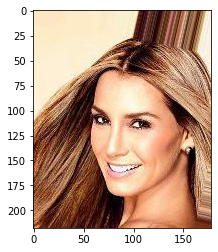

In [49]:
img = Image.open('../../data/celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [50]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [51]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [52]:
target_model = resnet.ResNet18(2)
#TM1: MS_FS
target_model.load_state_dict(torch.load("../../out/models/PIA_Sunglass/TM1.pth", map_location ='cpu'))
#MNS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MNS_30K_FNS_30K)_pth", map_location ='cpu'))
#MNS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MNS_30K_FS_30K)_pth", map_location ='cpu'))
#MS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_FNS_30K)_pth", map_location ='cpu'))
#MS_30_MNS_10_FS_30_FNS_10
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_MNS_10K_FS_30K_FNS_10K)_pth", map_location ='cpu'))
#MS_10_MNS_30_FS_10_FNS_30
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_10K_MNS_30K_FS_10K_FNS_30K)_pth", map_location ='cpu'
target_model.eval()
print("Model Loaded")

Model Loaded


<h1>SHAP Explain</h1>

In [53]:
target_batch = next(iter(test_loader))
target_images, target_labels = target_batch
target_baseline = target_images
    
target_explain = shap.DeepExplainer(target_model, target_baseline)

In [54]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())

torch.Size([3, 128, 128])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap_sum 2668.935971196669
shap_sum 2365.8726470914644


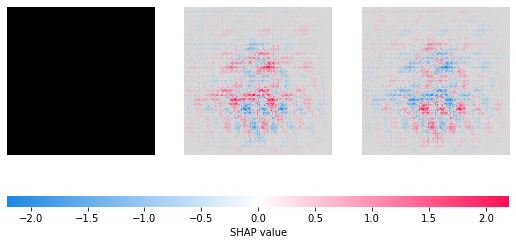

In [55]:
_target_shap_values = shap_plot(target_explain, r_img, 49152)

In [56]:
target_shap_values = torch.tensor(_target_shap_values)
target_shap_values.shape

torch.Size([2, 1, 3, 128, 128])

# SM1

shap_sum 20.243422651672923
shap_sum 18.823222000901126


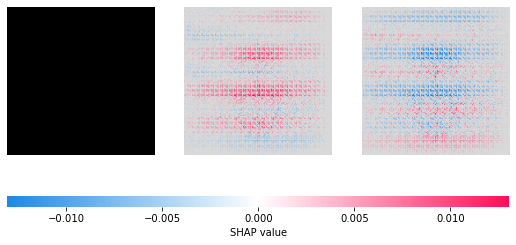

In [57]:
sm1_model = resnet.ResNet18(2)
sm1_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/sm1_5e.pth", map_location ='cpu'))
sm1_model.eval()
sm1_explain = shap.DeepExplainer(ms_fs_model, target_baseline)
sm1_shap_values = shap_plot(ms_fs_explain, r_img, 49152)

# SM2

shap_sum 1869.1834745863393
shap_sum 2098.4176582688524


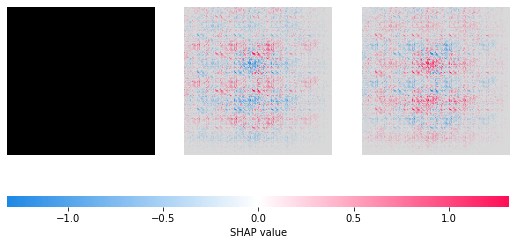

In [58]:
sm2_model = resnet.ResNet18(2)
sm2_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/sm2_5e.pth", map_location ='cpu'))
sm2_model.eval()
ms_fns_explain = shap.DeepExplainer(ms_fns_model, target_baseline)
ms_fns_shap_values = shap_plot(ms_fns_explain, r_img, 49152)

# SM3

shap_sum 511.39153633428475
shap_sum 483.62341826338525


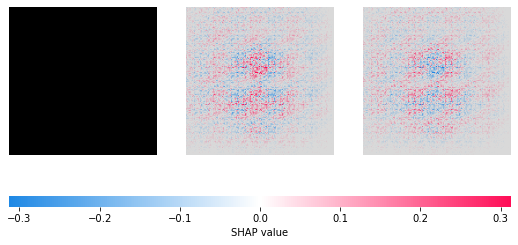

In [59]:
mns_fs_model = resnet.ResNet18(2)
mns_fs_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/sm_(ms_500_fns_500)_3e.pth", map_location ='cpu'))
mns_fs_model.eval()
mns_fs_explain = shap.DeepExplainer(mns_fs_model, target_baseline)
mns_fs_shap_values = shap_plot(mns_fs_explain, r_img, 49152)

# SM4

mns_fns_model = resnet.ResNet18(2)
mns_fns_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/sm_(mns_500_fs_500)_3e.pth", map_location ='cpu'))
mns_fns_model.eval()
mns_fns_explain = shap.DeepExplainer(mns_fns_model, target_baseline)
mns_fns_shap_values = shap_plot(mns_fns_explain, r_img, 49152)

# SM5

shap_sum 268.6887913881902
shap_sum 330.5394734454865


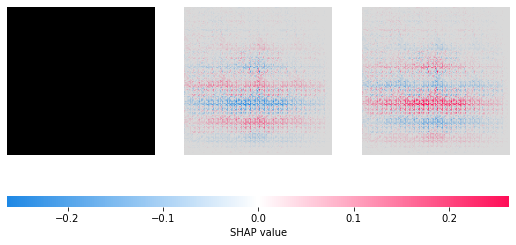

In [61]:
'''
ms1_mns4_fs1k_fns4_model = resnet.ResNet18(2)
ms1_mns4_fs1_fns4_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MS_1500_MNS_500_FS_1500_FNS_500)_3e_pth", map_location ='cpu'))
ms1_mns4_fs1_fns4_model.eval()
ms1_mns4_fs1_fns4_explain = shap.DeepExplainer(mns_fs_model, target_baseline)
ms1_mns4_fs1_fns4_shap_values = shap_plot(mns_fs_explain, r_img, 49152)
'''


# SM6

In [ ]:
'''
ms4_mns1_fs4_fns1_model = resnet.ResNet18(2)
ms4_mns1_fs4_fns1_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MS_500_MNS_1500_FS_500_FNS_1500)_3e_pth", map_location ='cpu'))
ms4_mns1_fs4_fns1_model.eval()
ms4_mns1_fs4_fns1_explain = shap.DeepExplainer(mns_fs_model, target_baseline)
ms4_mns1_fs4_fns1_shap_values = shap_plot(mns_fs_explain, r_img, 49152)

'''


# cosine similarity 

In [63]:
ms_fs_female = torch.tensor(ms_fs_shap_values[0]).view(-1) 
ms_fs_male = torch.tensor(ms_fs_shap_values[1]).view(-1)

In [64]:
mns_fns_female = torch.tensor(mns_fns_shap_values[0]).view(-1) 
mns_fns_male = torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [65]:
ms_fns_female = torch.tensor(ms_fns_shap_values[0]).view(-1) 
ms_fns_male = torch.tensor(ms_fns_shap_values[1]).view(-1) 

In [66]:
mns_fs_female = torch.tensor(mns_fs_shap_values[0]).view(-1) 
mns_fs_male = torch.tensor(mns_fs_shap_values[1]).view(-1) 

In [67]:
#ms1_mns4_fs1k_fns4k_female=torch.tensor(mns_fns_shap_values[0]).view(-1) 
#ms1_mns4_fs1k_fns4k_male= torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [68]:
#ms4_mns1_fs4_fns1_female=torch.tensor(mns_fns_shap_values[0]).view(-1) 
#ms4_mns1_fs4_fns1_male= torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [69]:
print(sim.cosine_similarity(r_shap_female, ms_fs_female))
print(sim.cosine_similarity(r_shap_female, mns_fns_female))
print(sim.cosine_similarity(r_shap_female, ms_fns_female))
print(sim.cosine_similarity(r_shap_female, mns_fs_female))
#print(sim.cosine_similarity(r_shap_female, ms1_mns4_fs1k_fns4k_female))
#print(sim.cosine_similarity(r_shap_female, ms4_mns1_fs4_fns1_female))

NameError: name 'r_shap_female' is not defined

In [ ]:
print(sim.cosine_similarity(r_shap_male, ms_fs_male))
print(sim.cosine_similarity(r_shap_male, mns_fns_male))
print(sim.cosine_similarity(r_shap_male, ms_fns_male))
print(sim.cosine_similarity(r_shap_male, mns_fs_male))
#print(sim.cosine_similarity(r_shap_male, ms1_mns4_fs1k_fns4k_male))
#print(sim.cosine_similarity(r_shap_male, ms4_mns1_fs4_fns1_male))